- 事故種別(基本)名について
  "医師搬送"は除外しても良さそう(医師を運んだだけ？、傷病名の記載もない)
  "転院搬送"も関係なさそう

- 収容機関名
  "不搬送"はいらないのでは？
  →不搬送を除外すると、傷病名が空欄は無くなったし、事故種別の医師搬送もなくなった

- 傷病名(大, 中, 小)分類(国)名
  一旦いらないかな

In [ ]:
import os
import sys

sys.path.append(os.path.join(os.path.abspath(''), '../src/'))
import pandas as pd

def clean_data(df):
    # 次の列の種類をstringに変更する: '覚知日付(元号年月日)'
    df = df.astype({'覚知日付(元号年月日)': 'string'})
    df = df.astype({'覚知日付(元号)名': 'string'})
    df = df.astype({'覚知日付(年)': 'string'})
    df = df.astype({'覚知日付(月)': 'string'})
    df = df.astype({'覚知日付(日)': 'string'})
    df = df.astype({'覚知時刻(時)': 'string'})
    df = df.astype({'覚知時刻(分)': 'string'})

    df["datestr"] = df["覚知日付(元号)名"] + df["覚知日付(年)"] +"年" + df["覚知日付(月)"] +"月"+ df["覚知日付(日)"]+"日" \
                    + " " + df["覚知時刻(時)"] + ":" + df["覚知時刻(分)"]
    df.drop(['覚知日付(元号年月日)','覚知日付(元号)名','覚知日付(年)',
             '覚知日付(月)','覚知日付(日)','覚知時刻(時)','覚知時刻(分)'],axis=1,inplace=True)
    import jp_datetime
    df["datetime"] = df["datestr"].apply(lambda x: 
                                         jp_datetime.parse_date(x,'%g%e年%m月%d日 %H:%M')
                                         )
    df.drop(['datestr'],axis=1,inplace=True)
    df = df.reindex(['datetime','出場隊名', '事故種別(基本)名', '覚知→現着(所要時間)', '覚知→病着(所要時間)', '年齢(歳)', '年齢区分名',
       '性別名', '傷病程度名', '傷病名', '傷病名大分類(国)名', '傷病名中分類(国)名', '傷病名小分類(国)名',
       '収容機関名', '行政区別区分名'], axis=1)
    

    # 病院に実際に来る場合を対象にしたいので、不搬送を除去
    df = df[df['収容機関名'] != "不搬送"]

    # 列を削除: '傷病名大分類(国)名'
    df = df.drop(columns=['傷病名大分類(国)名'])
    df = df.drop(columns=['傷病名中分類(国)名'])
    df = df.drop(columns=['傷病名小分類(国)名'])

    # count用に列を追加
    df["count"] = 1

    # 列で並べ替えます: 'datetime' (昇順)
    df = df.sort_values(['datetime'], ignore_index=True)
    
    return df

# excel形式のデータ読み込み
df = pd.concat(
    [pd.read_excel(r'../input/01_令和元年.xlsx'),
    pd.read_excel(r"../input/02_令和２年.xlsx"),
    pd.read_excel(r"../input/03_令和３年.xlsx"),
    pd.read_excel(r"../input/04_令和４年.xlsx"),
    pd.read_excel(r"../input/05_令和５年.xlsx")]
)
df_clean = clean_data(df.copy())
df_clean.head(3)
# df_clean.傷病名.to_csv("../output/傷病名一覧.csv",index=None)
# df_clean.to_pickle('../output/df_clean.pkl.gz', compression='gzip') # 圧縮有り

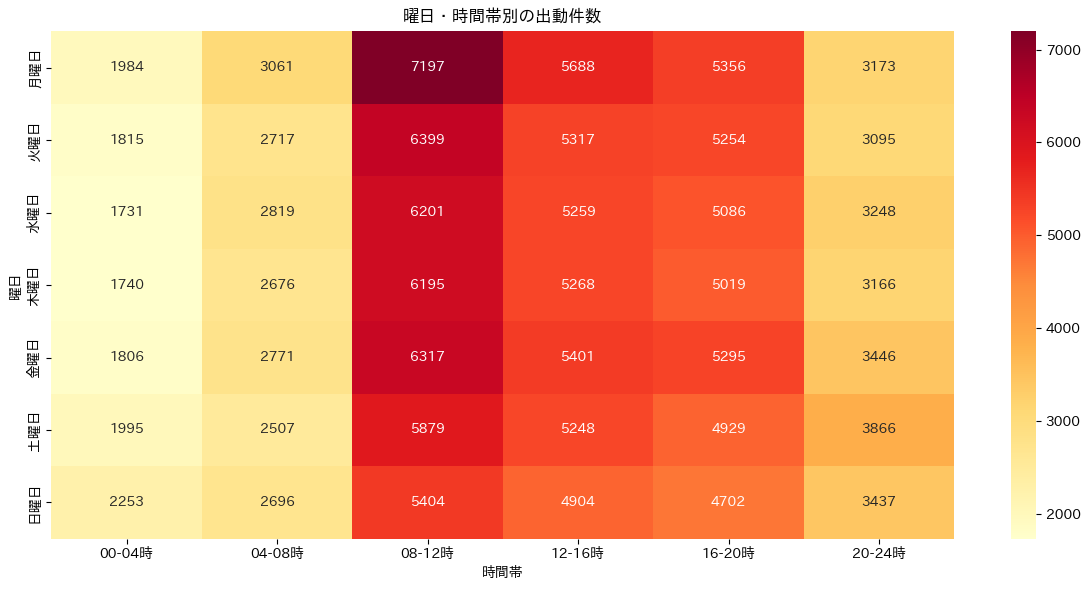


時間帯・曜日別の出動件数:
time_slot  00-04時  04-08時  08-12時  12-16時  16-20時  20-24時
weekday                                                  
月曜日          1984    3061    7197    5688    5356    3173
火曜日          1815    2717    6399    5317    5254    3095
水曜日          1731    2819    6201    5259    5086    3248
木曜日          1740    2676    6195    5268    5019    3166
金曜日          1806    2771    6317    5401    5295    3446
土曜日          1995    2507    5879    5248    4929    3866
日曜日          2253    2696    5404    4904    4702    3437


In [2]:
import os
import sys
import japanize_matplotlib
sys.path.append(os.path.join(os.path.abspath(''), '../src/'))
import pandas as pd
# 集計
df_clean = pd.read_pickle('../output/df_clean.pkl.gz', compression='gzip') # 圧縮有り
df_mod =  df_clean.copy()
df_mod.set_index(keys="datetime",inplace=True)
# 日付列から曜日を抽出
df_mod['weekday'] = df_mod.index.day_name()  # または .dt.weekday でも可
# 日本語の曜日表示にする場合
weekday_mapping = {
    'Monday': '月曜日',
    'Tuesday': '火曜日',
    'Wednesday': '水曜日',
    'Thursday': '木曜日',
    'Friday': '金曜日',
    'Saturday': '土曜日',
    'Sunday': '日曜日'
}
df_mod["weekday"] = df_mod["weekday"].map(weekday_mapping)

# 時間帯（4時間区切り）を作成
df_mod['time_slot'] = pd.to_datetime(df_mod.index).hour // 4
df_mod['time_slot'] = df_mod['time_slot'].map({
    0: '00-04時',
    1: '04-08時',
    2: '08-12時',
    3: '12-16時',
    4: '16-20時',
    5: '20-24時'
})
# 曜日と時間帯でグループ化して件数を集計
time_weekday_count = df_mod.groupby(['weekday', 'time_slot']).sum()["count"]

# ヒートマップ用のピボットテーブルを作成
pivot_counts = time_weekday_count.unstack()

# 曜日の順序を設定
weekday_order = ['月曜日', '火曜日', '水曜日', '木曜日', '金曜日', '土曜日', '日曜日']
pivot_counts = pivot_counts.reindex(weekday_order)

# ヒートマップの作成
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_counts, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('曜日・時間帯別の出動件数')
plt.ylabel('曜日')
plt.xlabel('時間帯')
plt.tight_layout()
plt.show()

# 集計結果を表示
print("\n時間帯・曜日別の出動件数:")
print(pivot_counts)

In [4]:
df_clean["傷病名"].unique()

array(['意識消失発作', '熱性痙攣', 'インフルエンザ、嘔吐', ..., '右鎖骨上挫創、前胸部挫創', '腎不全、腎炎',
       '左上腕動脈閉塞症'], shape=(24558,), dtype=object)

In [ ]:
weekday_stats

In [ ]:
def calculate_rolling_stats(df, value_column, ax,  window=7):
    """
    移動平均と移動標準偏差を計算する
    
    Parameters:
    df: DataFrame - 入力データ
    value_column: str - 分析対象の列名
    window: int - 移動窓の大きさ（デフォルト：7）
    ax : matplotlib.axes.Axes - プロット先のaxオブジェクト  

    Returns:
    df_stats: pandas.DataFrame - 移動統計量を追加したデータフレーム
    ax: matplotlib.axes.Axes - プロットを含むaxオブジェクト
    """

    # 移動平均と移動標準偏差を計算
    df_stats = df.copy()
    ma = df[value_column].rolling(window=window).mean()
    std = df[value_column].rolling(window=window).std()
    
    # プロット
    df_stats[value_column].plot(ax=ax, style='-', label='実測値', alpha=0.7)
    ma.plot(ax=ax, style='--', label='移動平均', color='red', linewidth=2)
    
    # 標準偏差のレンジをfill_between()で表示
    ax.fill_between(df_stats.index, 
                   ma - std, 
                   ma + std, 
                   alpha=0.2, 
                   color='red',
                   label='±1標準偏差')
    # 軸の最大値・最小値の設定
    ax.set_ylim(50, 170)
    ax.set_title('時系列データと移動平均（±標準偏差）')
    ax.set_xlabel('日付')
    ax.set_ylabel('値')
    ax.grid(True)
    ax.legend()
    
    return df_stats, ax
# 日付ベースで件数カウント
df_datebase = df_clean.groupby(pd.Grouper(key="datetime", freq="D")).sum()

# figとaxの作成は関数外で行う   
import matplotlib as mpl
import matplotlib.pyplot as plt
import japanize_matplotlib # 日本語対応

year = 2023
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1,1,1)
_, ax = calculate_rolling_stats(df_datebase[f"{year}/1/1":f"{year}/12/31"],"count", ax=ax)
title = ax.get_title()
ax.set_title(title + f"[{year}]")
fig.savefig(f"../output/{year}移動平均.svg", bbox_inches='tight')


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL # STL分解
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1,1,1)
df_clean.groupby(pd.Grouper(key="datetime", freq="D")).sum()["count"].plot(ax=ax)   

In [11]:
# stl分解してみる
stl = STL(df_clean.groupby(pd.Grouper(key="datetime", freq="D")).sum()["count"], period=7)
result = stl.fit()


In [ ]:
result.seasonal

In [ ]:
result.trend

In [ ]:
result.trend.plot()

In [ ]:
result.resid